## 4. 如何计算投资组合风险？

## 目录
1. 什么是Markowitz方差组合模型？
2. Portfolioopt的输入格式是什么？
3. 如何计算组合风险？
4. 如何将Markowitz可视化？

## 什么是Markowitz方差组合模型？
马克维茨投资组合理论的基本假设为：

(1)投资者是风险规避的，追求期望效用最大化；

(2)投资者根据收益率的期望值与方差来选择投资组合；

(3)所有投资者处于同一单期投资期。马克维茨提出了以期望收益及其方差(E，δ2)确定有效投资组合。

## Portfolioopt的输入格式是什么？
安装Portfolioopt: pip install Portfolioopt

In [1]:
import pandas as pd
import tushare as ts
import numpy as np
import portfolioopt as opt
import matplotlib.pyplot as plt

codes = ['000001', '600036', '600050']
stocks_dict = {}
for c in codes:
    stock = ts.get_k_data(c, start='2014-01-01', end='2016-12-31', ktype='D', autype='qfq')
    stock.index = pd.to_datetime(stock['date'], format='%Y-%m-%d')
    stock.pop('date')
    stocks_dict[c] = stock

pn = pd.Panel(stocks_dict)
data_r = pn.minor_xs('close').pct_change()[1:]
# print data_r
# if data_r.isnull().values.any():
#     data_r = data_r.fillna(method='ffill',inplace=True)
print data_r

              000001    600036    600050
date                                    
2014-01-03 -0.024644 -0.020589 -0.018710
2014-01-06 -0.021657 -0.004747 -0.028271
2014-01-07 -0.003536  0.005792  0.003045
2014-01-08  0.011262  0.010387 -0.012816
2014-01-09  0.005034  0.006593 -0.009908
2014-01-10  0.000000  0.009436 -0.006556
2014-01-13 -0.018519  0.007368  0.003473
2014-01-14  0.010207 -0.012009  0.009692
2014-01-15 -0.004133 -0.014807 -0.003085
2014-01-16  0.001691 -0.003813 -0.006534
2014-01-17 -0.017956  0.001914 -0.006923
2014-01-20 -0.015784 -0.009439 -0.003137
2014-01-21  0.005399  0.005672  0.010140
2014-01-22  0.037745  0.016131  0.013153
2014-01-23 -0.007609 -0.016763 -0.009908
2014-01-24 -0.003374 -0.008581  0.003451
2014-01-27 -0.023234 -0.009566 -0.013411
2014-01-28  0.009767  0.010578  0.013594
2014-01-29  0.005148  0.006713  0.003095
2014-01-30 -0.013813 -0.014241 -0.013027
2014-02-07 -0.001731 -0.002866  0.010073
2014-02-10  0.016711  0.009659  0.009972
2014-02-11  0.03

In [2]:
#主要的两个输入模式
exp_rets = data_r.mean()*252
cov_mat = data_r.cov()*252
print exp_rets
print cov_mat

000001    0.157781
600036    0.267599
600050    0.405151
dtype: float64
          000001    600036    600050
000001  0.116502  0.082639  0.090923
600036  0.082639  0.096628  0.067499
600050  0.090923  0.067499  0.220429


In [3]:
#计算目标收益的权重
portfolio_1 = opt.markowitz_portfolio(cov_mat, exp_rets, 0.2, allow_short=False, market_neutral=False)
print portfolio_1

000001    0.199260
600036    0.681691
600050    0.119049
dtype: float64


In [4]:
#计算最小方差的权重
portfolio_mv = opt.min_var_portfolio(cov_mat, allow_short=False)
print portfolio_mv

000001    0.199260
600036    0.681691
600050    0.119049
dtype: float64


In [5]:
#计算最优组合的权重
portfolio_tp = opt.tangency_portfolio(cov_mat, exp_rets, allow_short=False)
print portfolio_tp

000001    3.992272e-07
600036    6.000752e-01
600050    3.999244e-01
dtype: float64


In [6]:
#去除少于0.01权重的股票
weigth_t = opt.truncate_weights(portfolio_tp, min_weight=0.01, rescale=True)
print weigth_t

000001    0.000000
600036    0.600075
600050    0.399925
dtype: float64


## 如何计算组合风险？
$Portfolio Variance = x'\sum x$

x = weights

$\sum = Cov$

In [7]:
Portfolio_v = np.dot(weigth_t.T, np.dot(cov_mat,weigth_t))
P_sigma = np.sqrt(Portfolio_v)
print P_sigma

0.32007439625


## 如何将Markowitz可视化？

('sharpe:', 0.88294951703163038)


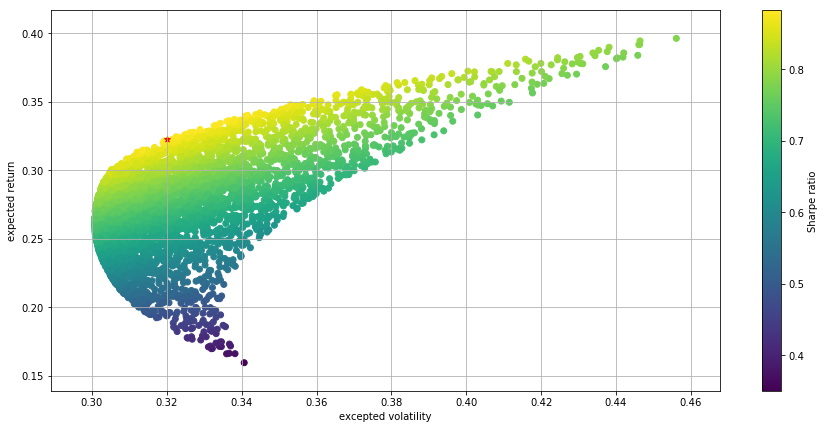

In [8]:
port_returns = []
port_variance = []
for p in range(4000):
    weights = np.random.rand(len(data_r.T))
    weights /= np.sum(weights)
    port_returns.append(np.sum(data_r.mean()*252*weights))
    port_variance.append(np.sqrt(np.dot(weights.T, np.dot(cov_mat,weights))))
port_returns = np.array(port_returns)
port_variance = np.array(port_variance)

risk_free = 0.04
P_r = np.sum(exp_rets*weigth_t)
sharpe = (P_r-risk_free)/P_sigma
print('sharpe:', sharpe)

plt.figure(figsize = (15,7))
plt.scatter(port_variance, port_returns, c=(port_returns-risk_free)/port_variance, marker='o')
plt.grid(True)
plt.xlabel('excepted volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.scatter(P_sigma, P_r, c='r', marker='*')
plt.show()

## 作业
选择三只或以上的股票，用Portfolioopt 将最优组合算出来，并将其可视化。